In [1]:
from sympy import *
init_printing()

In [2]:
from dataclasses import dataclass, field, replace
from functools import cache, cached_property
from re import U
from typing import Callable, Iterable, Optional, Self

from sympy.series.sequences import RecursiveSeq, sequence


@dataclass(frozen=True)
class Signal:
    recurrence_generator: Callable[[Symbol], Expr]
    initial: Optional[Iterable[Expr]] = None
    n: Symbol = Symbol("n", integer=True)

    @classmethod
    def undefined(cls, y: Function | str) -> Self:
        if isinstance(y, str):
            y = Function(y)
        return cls(lambda n: y(n))

    @classmethod
    def constant(cls, expr: Expr | str) -> Self:
        if isinstance(expr, str):
            expr = Symbol(expr)
        return cls(lambda n: expr)

    @classmethod
    def from_expr(cls, expr: Expr, n: Symbol) -> Self:
        return cls(lambda n: expr, n=n)

    @classmethod
    def zero(cls) -> Self:
        return cls.constant(Integer(0))

    @classmethod
    def recursive(cls, gen: Callable[[Self], Self], y: Function) -> Self:
        return gen(cls.undefined(y))

    def sequence(self, y: Function | str) -> RecursiveSeq:
        if isinstance(y, str):
            y = Function(y)
        return RecursiveSeq(self.recurrence_generator(self.n), y(self.n), self.n, initial=self.initial)

    def degree(self, y: Function) -> int:
        return self.sequence(y).degree

    def recurrence(self, y: Function | str):
        if isinstance(y, str):
            y = Function(y)
        return self.sequence(y).recurrence

    def with_initial(self, initial: Optional[Iterable[Expr]]) -> Self:
        return replace(self, initial=initial)

    def __call__(self, i: int) -> "Signal":
        return Signal(lambda n: self.recurrence_generator(n+i), initial=self.initial, n=self.n)

    def __getitem__(self, i: int) -> Expr:
        return self.recurrence_generator(self.n+i)

    def _expr_sympy(self, compute: Callable[[Expr], Expr]) -> "Signal":
        initial = None
        if self.initial is not None:
            initial = [compute(x) for x in self.initial]
        return Signal(lambda n: compute(self.recurrence_generator(n)), initial=initial, n=self.n)

    def _expr_signal(self, compute: Callable[[Symbol, Expr], Expr]) -> "Signal":
        return Signal(lambda n: compute(n, self.recurrence_generator(n)), n=self.n)

    def __add__(self, rhs: Self | Expr) -> "Signal":
        if isinstance(rhs, Signal):
            return self._expr_signal(lambda n, e: e + rhs.recurrence_generator(n))
        return self._expr_sympy(lambda e: e + rhs)

    def __sub__(self, rhs: Self | Expr) -> "Signal":
        if isinstance(rhs, Signal):
            return self._expr_signal(lambda n, e: e - rhs.recurrence_generator(n))
        return self._expr_sympy(lambda e: e - rhs)

    def __neg__(self) -> "Signal":
        return self._expr_sympy(lambda e: -e)

    def __mul__(self, rhs: Self | Expr) -> "Signal":
        if isinstance(rhs, Signal):
            return self._expr_signal(lambda n, e: e * rhs.recurrence_generator(n))
        return self._expr_sympy(lambda e: e * rhs)

    def __div__(self, rhs: Self | Expr) -> "Signal":
        if isinstance(rhs, Signal):
            return self._expr_signal(lambda n, e: e / rhs.recurrence_generator(n))
        return self._expr_sympy(lambda e: e / rhs)

    __truediv__ = __div__


@dataclass(frozen=True)
class Wave:
    a: Signal
    b: Signal

    def voltage(self) -> Signal:
        return (self.a + self.b) / Integer(2)


@dataclass(frozen=True)
class Wdf:
    @cache
    def impedance(self) -> Expr:
        return Integer(0)

    @cache
    def admittance(self) -> Expr:
        return Integer(1) / self.impedance()

    def wave(self, a: Signal) -> Wave: ...

    def voltage(self, a: Signal) -> Signal:
        return self.wave(a).voltage()

    def current(self, a: Signal) -> Signal:
        return self.voltage(a) / self.impedance()

In [3]:
from sympy import Expr


@dataclass(unsafe_hash=True, frozen=True)
class IdealVoltageSource(Wdf):
    Vs: Signal

    @cache
    def wave(self, a: Signal) -> Wave:
        return Wave(a, -a + self.Vs * Integer(2))


@dataclass(unsafe_hash=True, frozen=True)
class ResistiveVoltageSource(Wdf):
    R: Signal
    Vs: Signal

    @cache
    def impedance(self) -> Expr:
        return self.R[0]

    @cache
    def wave(self, a: Signal) -> Wave:
        return Wave(a, self.Vs)

In [4]:
from functools import cached_property
from sympy import Expr, Symbol

samplerate = Symbol("F_s", real=True, positive=True)
dt = 1 / samplerate


@dataclass(unsafe_hash=True, frozen=True)
class Resistor(Wdf):
    R: Signal

    @cache
    def impedance(self) -> Expr:
        return self.R[0]

    @cache
    def wave(self, a: Signal) -> Wave:
        return Wave(a, Signal.zero())


@dataclass(unsafe_hash=True, frozen=True)
class Capacitor(Wdf):
    C: Signal
    fs: Expr = samplerate

    @cache
    def admittance(self) -> Expr:
        return 2 * self.fs * self.C[0]

    @cache
    def impedance(self) -> Expr:
        return 1 / self.admittance()

    @cache
    def wave(self, a: Signal) -> Wave:
        return Wave(a, a(-1))

In [5]:
@dataclass(unsafe_hash=True, frozen=True)
class Series(Wdf):
    P1: Wdf
    P2: Wdf

    @cache
    def impedance(self) -> Expr:
        ra = self.P1.impedance()
        rb = self.P2.impedance()
        return ra + rb

    @cache
    def admittance(self) -> Expr:
        return 1 / self.impedance()

    @cache
    def p1_impedance(self) -> Expr:
        return self.P1.impedance() / self.impedance()

    @cache
    def p2_impedance(self) -> Expr:
        return self.P2.impedance() / self.impedance()

    @cache
    def wave(self, a: Signal) -> Wave:
        p1 = self.P1.wave(a(-1))
        p2 = self.P2.wave(a(-1))
        b1 = -(a + p1.b + p2.b) * self.p1_impedance() + p1.b

        p1 = self.P1.wave(b1)
        p2 = self.P2.wave(-a - b1)
        b = p1.b + p2.b
        return Wave(a, b)


@dataclass(unsafe_hash=True, frozen=True)
class Parallel(Wdf):
    P1: Wdf
    P2: Wdf

    @cache
    def admittance(self) -> Expr:
        g1 = self.P1.admittance()
        g2 = self.P2.admittance()
        return g1 + g2

    @cache
    def impedance(self) -> Expr:
        return 1 / self.admittance()

    @cache
    def p1_impedance(self) -> Expr:
        return self.P1.admittance() / self.admittance()

    @cache
    def wave(self, a: Signal) -> Wave:
        p1 = self.P1.wave(a(-1))
        p2 = self.P2.wave(a(-1))
        bdiff = p2.b - p1.b
        btemp = -bdiff * self.p1_impedance()
        b = p2.b + btemp
        return Wave(a, b)

In [6]:
@dataclass(frozen=True)
class Inverter(Wdf):
    P: Wdf

    @cache
    def impedance(self) -> Expr:
        return self.P.impedance()

    @cache
    def admittance(self) -> Expr:
        return self.P.admittance()

    def wave(self, a: Signal) -> Wave:
        w = self.P.wave(-a)
        return Wave(a, -w.b)


@dataclass(frozen=True)
class Probe(Wdf):
    P: Wdf
    symbol: Symbol = Symbol("V_out", real=True)

    def impedance(self) -> Expr:
        return self.P.impedance()

    def admittance(self) -> Expr:
        return self.P.admittance()

    def wave(self, a: Signal) -> Wave:
        w = self.P.wave(a)
        return Wave(-w.b + 2 * self.symbol, -w.a + 2 * self.symbol)

In [7]:
from itertools import repeat
from typing import ClassVar


@dataclass(frozen=True)
class Root:
    A: Wdf
    B: Wdf
    wb: ClassVar[Function] = Function("w_b")

    def eval(self, y: Function = wb) -> Signal:
        def recurrence(sig: Signal):
            w = self.A.wave(sig(-1))
            return self.B.wave(w.b).b

        return Signal.recursive(recurrence, y)
    
    def sequence_for(self, symbol: Symbol, y: Function = wb) -> Signal:
        def gen(n: Symbol) -> Expr:
            sig = self.eval(y)
            recurrence = sig.recurrence(y).rhs
            return solve(recurrence, symbol, dict=True)[0][symbol]
        return Signal(gen)

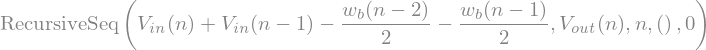

In [8]:
r = Symbol("R", real=True, positive=True)
vin = Signal.undefined("V_in")
out = Probe(Resistor(Signal.constant(r)))
net = Root(IdealVoltageSource(vin), Inverter(Series(Resistor(Signal.constant(r)), out)))
sig = net.sequence_for(out.symbol)
sig.sequence("V_out")

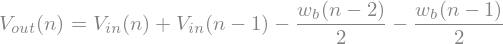

In [9]:
sig.recurrence("V_out")

In [10]:
vin = Signal.undefined(Function("V_in"))
net = Parallel(
    ResistiveVoltageSource(vin, Signal.constant("R")),
    Capacitor(Signal.constant("C"))
)

net.wave()

TypeError: Parallel.wave() missing 1 required positional argument: 'a'